## Base de dados
---

**Brazilian E-Commerce Public Dataset by Olist**


Este é um conjunto de dados públicos de e-commerce brasileiro de pedidos feitos na Olist Store. O conjunto de dados tem informações de 100 mil pedidos de 2016 a 2018 feitos em vários marketplaces no Brasil. Suas funcionalidades permitem visualizar um pedido a partir de múltiplas dimensões: desde o status do pedido, preço, pagamento e desempenho do frete até a localização do cliente, atributos do produto e, finalmente, avaliações escritas pelos clientes. Também conta um conjunto de dados de geolocalização que relaciona os CEPs brasileiros às coordenadas lat/lng.

Estes são dados comerciais reais que foram anonimizados e as referências às empresas e parceiros no texto da revisão foram substituídas pelos nomes das grandes casas de Game of Thrones.

Este conjunto de dados foi fornecido pela Olist, a maior loja de departamentos dos marketplaces brasileiros. A Olist conecta pequenas empresas de todo o Brasil a canais sem complicações e com um único contrato. Esses comerciantes podem vender seus produtos através da Olist Store e enviá-los diretamente aos clientes usando os parceiros de logística da Olist.

Depois que um cliente compra o produto da Olist Store, um vendedor é notificado para atender esse pedido. Assim que o cliente recebe o produto, ou vence a data prevista de entrega, o cliente recebe uma pesquisa de satisfação por e-mail onde pode dar uma nota da experiência de compra e anotar alguns comentários.

Atenção
- Um pedido pode ter vários itens.
- Cada item pode ser atendido por um vendedor distinto.
- Todo o texto identificando lojas e parceiros foi substituído pelos nomes das grandes casas de Game of Thrones.

**Data Schema**

<img src="https://i.imgur.com/HRhd2Y0.png"
     alt="Data Schema"
     style="float: left; margin-right: 10px;" />

## Carregamento dos dados
---


Nessa etapa, todos os dados são carregados e separados em datasets.

In [1]:
#importando as blibliotecas necessárias
import os
import string
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from random import choices
import calendar
import pickle
from pandas.tseries.offsets import DateOffset
from sklearn import metrics

In [3]:
#caminho para a localização dos datasets
PATH = "./bases/"
#PATH = "./e-commerce/"

#dataset com informações dos clientes e localização
df_customers = pd.read_csv(PATH + "olist_customers_dataset.csv")
#dataset com CEPs e coordenadas
df_geolocation = pd.read_csv(PATH + "olist_geolocation_dataset.csv")
#dataset com dados dos itens de cada transação
df_items = pd.read_csv(PATH + "olist_order_items_dataset.csv")
#dataset com informações do pagamento de cada transação
df_payment = pd.read_csv(PATH + "olist_order_payments_dataset.csv")
#dataset com reviews realizados pelos clientes
df_reviews = pd.read_csv(PATH + "olist_order_reviews_dataset.csv")
#dataset com os dados de cada transação
df_orders = pd.read_csv(PATH + "olist_orders_dataset.csv")
#dataset com informações sobre cada produto
df_products = pd.read_csv(PATH + "olist_products_dataset.csv")
#dataset com dados sobre os vendedores
df_sellers = pd.read_csv(PATH + "olist_sellers_dataset.csv")
#dataset que traduz os nomes de categoria (Pt -> En)
df_category = pd.read_csv(PATH + "product_category_name_translation.csv")

## Análises dos datasets
----


Etapa onde os datasets são visualizados e analisados para verificar a qualidade e determinar se as informações coletadas estão bem distribuídas, identificar problemas e fazer as relações e ajustes necessários.

In [4]:
#visualização geral dos datasets
datasets = [df_customers, df_geolocation, df_orders, df_items, df_payment, df_reviews, df_products, df_sellers]
names = ['df_customers', 'df_geolocation', 'df_orders', 'df_items', 'df_payment', 'df_reviews', 'df_products', 'df_sellers']

data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qtd_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['columns_name']= [', '.join(list(df.columns)) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient(cmap='Greys')

,dataset,n_rows,n_cols,null_amount,qtd_null_columns,columns_name,null_columns
0,df_customers,99441,5,0,0,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",
1,df_geolocation,1000163,5,0,0,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",
2,df_orders,99441,8,4908,3,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date","order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,df_items,112650,7,0,0,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",
4,df_payment,103886,5,0,0,"order_id, payment_sequential, payment_type, payment_installments, payment_value",
5,df_reviews,99224,7,145903,2,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp","review_comment_title, review_comment_message"
6,df_products,32951,9,2448,8,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm","product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,df_sellers,3095,4,0,0,"seller_id, seller_zip_code_prefix, seller_city, seller_state",


### Orders dataset

Dataset principal contendo as transações dos clientes

In [5]:
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [ ]:
#verificando se as transações são distintas
duplicateRowsOrders = df_orders[df_orders.duplicated()]
print("Número de transações: ",df_orders.order_id.nunique())
print("Transações duplicadas: ",duplicateRowsOrders.shape[0])

Número de transações:  99441
Transações duplicadas:  0


In [ ]:
#verificado intervalo da base
print("Data da primeira transação: ",df_orders.order_purchase_timestamp.min())
print("Data da última transação: ",df_orders.order_purchase_timestamp.max())

Data da primeira transação:  2016-09-04 21:15:19
Data da última transação:  2018-10-17 17:30:18


In [ ]:
#status das transações
status_order = df_orders.groupby('order_status')['order_id'].nunique().sort_values(ascending=False).reset_index()
status_order.columns = ['status','qtd_transações']
status_order

,status,qtd_transações
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [ ]:
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Os valores nulos existentes correspondem a datas de aprovação, de entrega e transporte ainda não inseridos

In [ ]:
#filtrando para todas as transações finalizadas
df_orders = df_orders.query("order_status == 'delivered'")
print("Quantidade de transações finalizadas: ",df_orders.order_id.count())

Quantidade de transações finalizadas:  96478


### Customer dataset

dataset contendo as informações dos clientes

In [ ]:
df_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [ ]:
print("Quantidade de clientes: ",df_customers.customer_unique_id.nunique())
print("Quantidade de cidades: ",df_customers.customer_city.nunique())

Quantidade de clientes:  96096
Quantidade de cidades:  4119


In [ ]:
#quantidade de clientes por cidade
city_status = df_customers.groupby('customer_city')['customer_unique_id'].nunique().reset_index()
city_status = city_status.sort_values('customer_unique_id',ascending = False)
city_status.columns = ['cidade','qtd_clientes']
city_status.head(10)

,cidade,qtd_clientes
3597,sao paulo,14984
3155,rio de janeiro,6620
453,belo horizonte,2672
558,brasilia,2069
1143,curitiba,1465
707,campinas,1398
2964,porto alegre,1326
3247,salvador,1209
1529,guarulhos,1153
3428,sao bernardo do campo,908


### Payment dataset

dataset referente ao pagamento por transação, onde cada transação pode ter mais de um meio de pagamento (**payment_sequential**) com diversas parcelas  (**payment_installments**)

In [ ]:
df_payment

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [ ]:
#pagamento total por transação
paid= df_payment[['order_id','payment_value']].groupby('order_id').sum().reset_index()
paid

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,386.53
99437,fffce4705a9662cd70adb13d4a31832d,116.85
99438,fffe18544ffabc95dfada21779c9644f,64.71


### Items dataset

dataset com os itens atrelados a cada transação, onde **order_item_id** se refere a quantidade de items.

In [ ]:
df_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [ ]:
df_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [ ]:
#verificando se todas as transações finalizadas possuem itens
new_df = pd.merge(df_items, df_orders, on = 'order_id')
new_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110192,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00
110193,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00
110194,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00
110195,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25 00:00:00


In [ ]:
#quantidade de transações finalizadas com produtos
status = new_df.groupby('order_status')['order_id'].nunique().sort_values(ascending=False).reset_index()
status.columns = ['order_status','qtd_orders']
status

,order_status,qtd_orders
0,delivered,96478


In [ ]:
#quantidade de transações finalizadas
status2 = df_orders.groupby('order_status')['order_id'].nunique().sort_values(ascending=False).reset_index()
status2.columns = ['order_status','qtd_orders']
status2

,order_status,qtd_orders
0,delivered,96478


In [ ]:
#valor do frete para cada transação
df_frete = df_items.groupby('order_id').freight_value.sum().reset_index()
df_frete

,order_id,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,13.29
1,00018f77f2f0320c557190d7a144bdd3,19.93
2,000229ec398224ef6ca0657da4fc703e,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,18.14
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,36.53
98663,fffce4705a9662cd70adb13d4a31832d,16.95
98664,fffe18544ffabc95dfada21779c9644f,8.72


### Products dataset

dataset com as características dos produtos  

In [ ]:
df_products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [ ]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
#categorias distintas
df_products['product_category_name'].nunique()

73

In [ ]:
#produtos sem categorias
df_products['product_category_name'].isnull().sum()

610

In [ ]:
df_products.query('product_category_name.isnull()',engine='python')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [ ]:
df_items.sort_values(['order_id','order_item_id'], ascending = False)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
...,...,...,...,...,...,...,...
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93


In [ ]:
#quantidade e categoria dos produtos por transação
df_order_item = pd.merge(df_items,df_products, on = 'product_id')
df_order_item = df_order_item[['order_id','order_item_id','product_category_name']]
df_order_item = df_order_item.sort_values('order_item_id',ascending = False)
df_order_item.query("order_id == '00143d0f86d6fbd9f9b38ab440ac16f5'")

,order_id,order_item_id,product_category_name
1317,00143d0f86d6fbd9f9b38ab440ac16f5,3,esporte_lazer
1316,00143d0f86d6fbd9f9b38ab440ac16f5,2,esporte_lazer
1315,00143d0f86d6fbd9f9b38ab440ac16f5,1,esporte_lazer


In [ ]:
produtos_por_compra = df_order_item.groupby('order_id').first().reset_index()
produtos_por_compra.columns = ['order_id','qtd_produto','tipo_produto']
produtos_por_compra

,order_id,qtd_produto,tipo_produto
0,00010242fe8c5a6d1ba2dd792cb16214,1,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,1,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ferramentas_jardim
...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1,utilidades_domesticas
98662,fffcd46ef2263f404302a634eb57f7eb,1,informatica_acessorios
98663,fffce4705a9662cd70adb13d4a31832d,1,esporte_lazer
98664,fffe18544ffabc95dfada21779c9644f,1,informatica_acessorios


### Geolocation dataset

dataset contendo informações mais detalhadas sobre a localização dos clientes

In [ ]:
df_geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


### Sellers dataset

dataset com informações dos vendedores

In [ ]:
df_sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [ ]:
df_sellers.seller_id.nunique()

3095

## Análises das transações

Etapa onde as transações são avaliadas e atribuidas com suas respectivas variáveis

In [ ]:
#tabela com as transações e clientes relacionados e valores referentes

# clientes por transação
df_transactions = pd.merge(df_orders[['order_id','order_status','customer_id','order_purchase_timestamp']],df_customers,on='customer_id')

# produtos por transação
df_transactions = pd.merge(df_transactions,produtos_por_compra, on = 'order_id')

# pagamento por transação
df_transactions = pd.merge(df_transactions, paid, on='order_id')

# frete por transação
df_transactions = pd.merge(df_transactions,df_frete, how = 'left',on = 'order_id')


df_transactions.drop(['customer_zip_code_prefix','customer_city','customer_state','customer_id'],axis=1,inplace=True)
df_transactions

,order_id,order_status,order_purchase_timestamp,customer_unique_id,qtd_produto,tipo_produto,payment_value,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,1,utilidades_domesticas,38.71,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,1,perfumaria,141.46,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,1,automotivo,179.12,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,1,pet_shop,72.20,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,1,papelaria,28.62,8.72
...,...,...,...,...,...,...,...,...
96472,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,1,beleza_saude,85.08,13.08
96473,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,1,bebes,195.00,20.10
96474,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,1,eletrodomesticos_2,271.01,65.02
96475,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,2,informatica_acessorios,441.16,81.18


In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96477 entries, 0 to 96476
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96477 non-null  object 
 1   order_status              96477 non-null  object 
 2   order_purchase_timestamp  96477 non-null  object 
 3   customer_unique_id        96477 non-null  object 
 4   qtd_produto               96477 non-null  int64  
 5   tipo_produto              95145 non-null  object 
 6   payment_value             96477 non-null  float64
 7   freight_value             96477 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 6.6+ MB


In [ ]:
#verificando transações onde os produtos não tem nome
df_transactions.query('tipo_produto.isnull()',engine='python')

,order_id,order_status,order_purchase_timestamp,customer_unique_id,qtd_produto,tipo_produto,payment_value,freight_value
104,bfe42c22ecbf90bc9f35cf591270b6a7,delivered,2018-01-27 22:04:34,34c58672601f2c6d29db7efd1f6bf958,1,None,42.40,15.10
174,58ac1947c1a9067b9f416cba6d844a3f,delivered,2017-09-13 09:18:50,5cbf29b2dcf212a6a5d864b887238c72,1,None,124.16,14.16
222,e22b71f6e4a481445ec4527cb4c405f7,delivered,2017-04-22 13:48:18,1268b060098ed3f22c2e7c34cc72a1a8,1,None,34.24,11.74
256,a094215e786240fcfefb83d18036a1cd,delivered,2018-02-08 18:56:45,f5cb81f98962f7504bef1e75579b6dff,1,None,132.05,9.06
320,6f841dde94727854eaff3f66432c80ea,delivered,2018-01-02 19:20:35,5f38cc36e507c4d880489be38964af19,1,None,192.95,24.05
...,...,...,...,...,...,...,...,...
96117,1a10e938a1c7d8e5eecc3380f71ca76b,delivered,2018-07-25 08:58:35,75fe53e03a8a9797acb680ce8710da8b,1,None,146.19,18.99
96258,e33865519137f5737444109ae8438633,delivered,2018-05-28 00:44:06,82ffeb20040f58e6c008e4402fa6f992,1,None,42.14,8.29
96265,f0dd9af88d8ef5a8e4670fbbedaf19c4,delivered,2017-09-02 20:38:29,1d627d8a6e1e33ea8eeeb7a17d998660,1,None,100.25,15.35
96271,272874573723eec18f23c0471927d778,delivered,2017-12-20 23:10:33,da59579685bd771fdd4f90fb50d28cd3,1,None,132.05,9.06


In [ ]:
#atribuindo produtos sem nome como "diversos"
df_transactions['tipo_produto'] = df_transactions['tipo_produto'].fillna('misc')

In [ ]:
df_transactions.isnull().sum()

order_id                    0
order_status                0
order_purchase_timestamp    0
customer_unique_id          0
qtd_produto                 0
tipo_produto                0
payment_value               0
freight_value               0
dtype: int64

In [ ]:
#transformando data de string para timestamp
df_transactions['order_purchase_timestamp']=pd.to_datetime(df_transactions.order_purchase_timestamp)

In [ ]:
#Cálculo da receita liquida
df_transactions['receita_liquida'] = df_transactions['payment_value'] - df_transactions['freight_value']

In [ ]:
#quantidade de clientes com transações finalizadas
df_transactions.customer_unique_id.nunique()

93357

In [ ]:
#Análise mensal das transações
monthly_transactions = df_transactions.copy()
monthly_transactions['order_purchase_year'] = monthly_transactions.order_purchase_timestamp.apply(lambda x: x.year)
monthly_transactions['order_purchase_month'] = monthly_transactions.order_purchase_timestamp.apply(lambda x: x.month)
monthly_transactions['month_year'] = monthly_transactions['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
monthly_transactions['month_year'] = monthly_transactions['order_purchase_year'].astype(str) + '-' + monthly_transactions['month_year'].astype(str)

In [ ]:
#receita liquida mensal
monthly_transactions_m = monthly_transactions.groupby(['month_year'])['receita_liquida'].sum().reset_index()
monthly_transactions_m.head()

,month_year,receita_liquida
0,2016-10,40401.16
1,2016-12,10.90
2,2017-01,111861.66
3,2017-02,234282.73
4,2017-03,359237.29


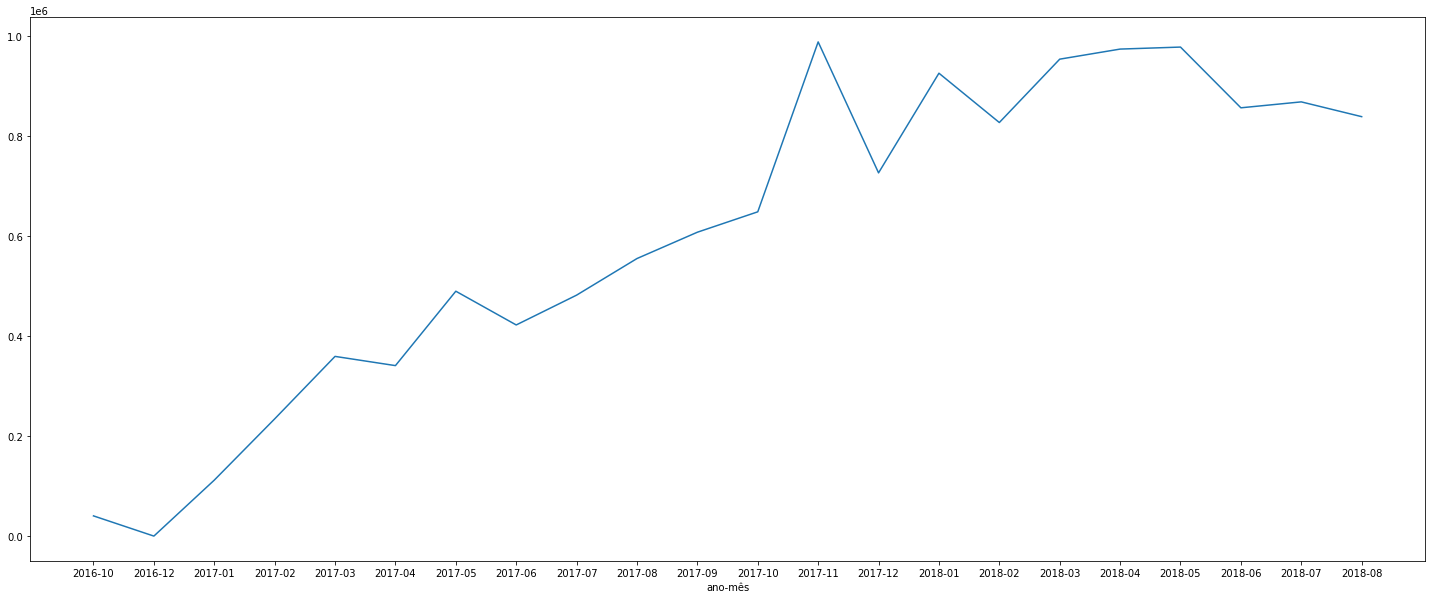

In [ ]:
#receita liquida mensal
plt.figure(figsize=(25,10))
plt.plot(monthly_transactions_m['month_year'],monthly_transactions_m['receita_liquida'])
plt.xlabel("ano-mês")
plt.show()

In [ ]:
#porcentagem de cliente por qtd de transações
df_count_cust = df_transactions.groupby(['customer_unique_id']).count().reset_index()
df_count_cust["order_count"] = df_count_cust["order_id"]
df_count_cust = df_count_cust.drop(["order_id", "payment_value","order_status","order_purchase_timestamp"], axis=1)
df_count_cust = df_count_cust.groupby(["order_count"]).count().reset_index().rename(columns={"customer_unique_id": "num_customer"})
df_count_cust["percentage_customer"] = 100.0 * df_count_cust["num_customer"] / df_count_cust["num_customer"].sum()
df_count_cust[['order_count','num_customer','percentage_customer']]

,order_count,num_customer,percentage_customer
0,1,90556,96.999689
1,2,2573,2.756087
2,3,181,0.193879
3,4,28,0.029992
4,5,9,0.009640
5,6,5,0.005356
6,7,3,0.003213
7,9,1,0.001071
8,15,1,0.001071


97% dos clientes realizaram apenas uma transação durante o periodo da base

## Análises dos clientes
---

Nessa etapa será avaliado o comportamento dos clientes,analisando as praticas de compra e ciclo de vida

### Análise RFM

Inicialmente é realizado a análise RFM dos clientes, que se refere a:


*   **Recência**:  Tempo entre ultima transação e fim da base
*   **Frequência**: Quantidade de transações realizadas
*   **Valor Monetário**: Valor gerado pelo cliente  







**Recência**


In [ ]:
global_recency = pd.DataFrame(df_transactions.groupby('customer_unique_id').order_purchase_timestamp.max())
global_recency.columns = ['ultima_compra']
global_recency

,ultima_compra
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16


In [ ]:
#identificando ultima compra da base
global_recency['ultima_compra'].max()

Timestamp('2018-08-29 15:00:37')

In [ ]:
#recencia global -> dias desde a ultima compra
global_recency['recencia'] = global_recency['ultima_compra'].max() - global_recency['ultima_compra']
global_recency['recencia']= global_recency['recencia'].dt.days
global_recency

,ultima_compra,recencia
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,111
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,114
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,536
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,320
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,287
...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,446
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,261
ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,567


**Frequência**

In [ ]:
global_frequency=pd.DataFrame(df_transactions.groupby('customer_unique_id')['order_id'].count())
global_frequency.columns = ['qtd_transacoes']
global_frequency

,qtd_transacoes
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0000f46a3911fa3c0805444483337064,1
0000f6ccb0745a6a4b88665a16c9f078,1
0004aac84e0df4da2b147fca70cf8255,1
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1
fffea47cd6d3cc0a88bd621562a9d061,1
ffff371b4d645b6ecea244b27531430a,1


**Valor Monetário**

In [ ]:
#gasto total de cada cliente
global_monetary=pd.DataFrame(df_transactions[['customer_unique_id','receita_liquida']].groupby('customer_unique_id')['receita_liquida'].sum())
global_monetary

,receita_liquida
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
0000f46a3911fa3c0805444483337064,69.00
0000f6ccb0745a6a4b88665a16c9f078,25.99
0004aac84e0df4da2b147fca70cf8255,180.00
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
fffea47cd6d3cc0a88bd621562a9d061,64.89
ffff371b4d645b6ecea244b27531430a,89.90


**Tabela RFM**

In [ ]:
df_rfm=pd.merge(global_recency,global_frequency,on='customer_unique_id')
df_rfm=pd.merge(df_rfm,global_monetary,on='customer_unique_id')

In [ ]:
df_rfm.drop(['ultima_compra'],axis=1,inplace=True)
df_rfm.columns=['rfm_recency','rfm_frequency','rfm_monetary']
df_rfm.reset_index()

,customer_unique_id,rfm_recency,rfm_frequency,rfm_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,536,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00
...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,446,1,1570.00
93353,fffea47cd6d3cc0a88bd621562a9d061,261,1,64.89
93354,ffff371b4d645b6ecea244b27531430a,567,1,89.90
93355,ffff5962728ec6157033ef9805bacc48,118,1,115.00


In [ ]:
df_rfm.describe()

,rfm_recency,rfm_frequency,rfm_monetary
count,93357.000000,93357.000000,93357.000000
mean,236.936673,1.033420,141.651881
std,152.584315,0.209099,215.713425
min,0.000000,1.000000,0.850000
25%,113.000000,1.000000,47.750000
50%,218.000000,1.000000,89.790000
75%,345.000000,1.000000,154.890000
max,694.000000,15.000000,13440.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


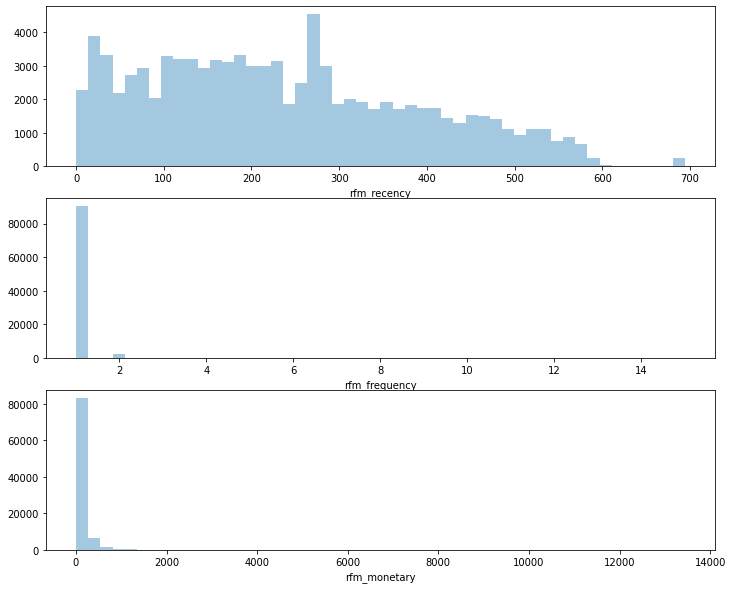

In [ ]:
# RFM destribuições
plt.figure(figsize=(12,10))

# Rencency
plt.subplot(3, 1, 1); sns.distplot(df_rfm['rfm_recency'],kde=False)
# Frequency
plt.subplot(3, 1, 2); sns.distplot(df_rfm['rfm_frequency'],kde=False)
# Monetary
plt.subplot(3, 1, 3); sns.distplot(df_rfm['rfm_monetary'],kde=False)

plt.show()

In [ ]:
#dataframe com clientes unicos
df_client = df_customers.drop('customer_id', axis=1)
df_client = df_client.drop_duplicates(subset = ['customer_unique_id'], keep = 'first')
df_client

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [ ]:
#selecionando clientes das transações finalizadas
clientes_final = df_transactions['customer_unique_id'].drop_duplicates()
mask_cliente = df_client['customer_unique_id'].isin(clientes_final)
df_client = df_client.loc[mask_cliente]
df_client

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [ ]:
df_client.customer_unique_id.nunique()

93357

In [ ]:
#primeira compra por cliente
primeira_compra = df_transactions.groupby("customer_unique_id").order_purchase_timestamp.min().reset_index()
primeira_compra.columns = ['customer_unique_id','primeira_compra']

#ultima compra por cliente
ultima_compra = df_transactions.groupby("customer_unique_id").order_purchase_timestamp.max().reset_index()
ultima_compra.columns = ['customer_unique_id','ultima_compra']

#new customer dataset
df_client = pd.merge(df_client, primeira_compra, on = "customer_unique_id")
df_client = pd.merge(df_client,ultima_compra, on = "customer_unique_id")

# + RFM table
df_client = pd.merge(df_client,df_rfm, on = 'customer_unique_id')
df_client

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,primeira_compra,ultima_compra,rfm_recency,rfm_frequency,rfm_monetary
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,2017-05-16 15:05:35,2017-05-16 15:05:35,469,1,124.99
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,2018-01-12 20:48:24,2018-01-12 20:48:24,228,1,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,2018-05-19 16:07:45,2018-05-19 16:07:45,101,1,139.94
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,2018-03-13 16:06:38,2018-03-13 16:06:38,168,1,149.94
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,2018-07-29 09:51:30,2018-07-29 09:51:30,31,1,230.00
...,...,...,...,...,...,...,...,...,...
93352,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,2018-04-07 15:48:17,2018-04-07 15:48:17,143,1,74.90
93353,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,2018-04-04 08:20:22,2018-04-04 08:20:22,147,1,114.90
93354,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,2018-04-08 20:11:50,2018-04-08 20:11:50,142,1,37.00
93355,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,2017-11-03 21:08:33,2017-11-03 21:08:33,298,1,689.00


In [ ]:
#ticket médio por cliente
df_client['ticket_medio'] = df_client['rfm_monetary'] / df_client['rfm_frequency']

#tempo de vida dos clientes
df_client['retencao'] = (df_client['ultima_compra'] - df_client['primeira_compra']).dt.days

df_client

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,primeira_compra,ultima_compra,rfm_recency,rfm_frequency,rfm_monetary,ticket_medio,retencao
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,2017-05-16 15:05:35,2017-05-16 15:05:35,469,1,124.99,124.99,0
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,2018-01-12 20:48:24,2018-01-12 20:48:24,228,1,289.00,289.00,0
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,2018-05-19 16:07:45,2018-05-19 16:07:45,101,1,139.94,139.94,0
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,2018-03-13 16:06:38,2018-03-13 16:06:38,168,1,149.94,149.94,0
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,2018-07-29 09:51:30,2018-07-29 09:51:30,31,1,230.00,230.00,0
...,...,...,...,...,...,...,...,...,...,...,...
93352,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,2018-04-07 15:48:17,2018-04-07 15:48:17,143,1,74.90,74.90,0
93353,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,2018-04-04 08:20:22,2018-04-04 08:20:22,147,1,114.90,114.90,0
93354,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,2018-04-08 20:11:50,2018-04-08 20:11:50,142,1,37.00,37.00,0
93355,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,2017-11-03 21:08:33,2017-11-03 21:08:33,298,1,689.00,689.00,0


### Sobrevivencia dos Clientes

Como não existe um critério para determinação da "morte" dos clientes, é realizado uma análise para encontrar a quantidade de dias sem transacionar onde o cliente tem a maior probabilidade de abandonar o ecommerce (Churn)

In [ ]:
#copia das transações
df_transactions_2 = df_transactions.copy()

In [ ]:
#ordenando por cliente e data de transação por cliente
df_transactions_2 = df_transactions_2.sort_values(['customer_unique_id','order_purchase_timestamp'],ascending=[True,True])

In [ ]:
#compra anterior do cliente
df_transactions_2['compra_anterior'] = df_transactions_2.groupby('customer_unique_id')['order_purchase_timestamp'].shift()

#diferenca de dias entre as transações
df_transactions_2['date_diff'] = df_transactions_2['order_purchase_timestamp'] - df_transactions_2['compra_anterior']

#filtrando os clientes one shot (sem data anterior)
df_transactions_2 = df_transactions_2.query("date_diff != 'NaT'").sort_values(['customer_unique_id','order_purchase_timestamp'])

#transformando a data em dias
df_transactions_2['date_diff']= df_transactions_2['date_diff'].dt.days

#filtrando clientes com transações no mesmo dia (data_diff = 0)
df_transactions_2 = df_transactions_2.query("date_diff > 0")

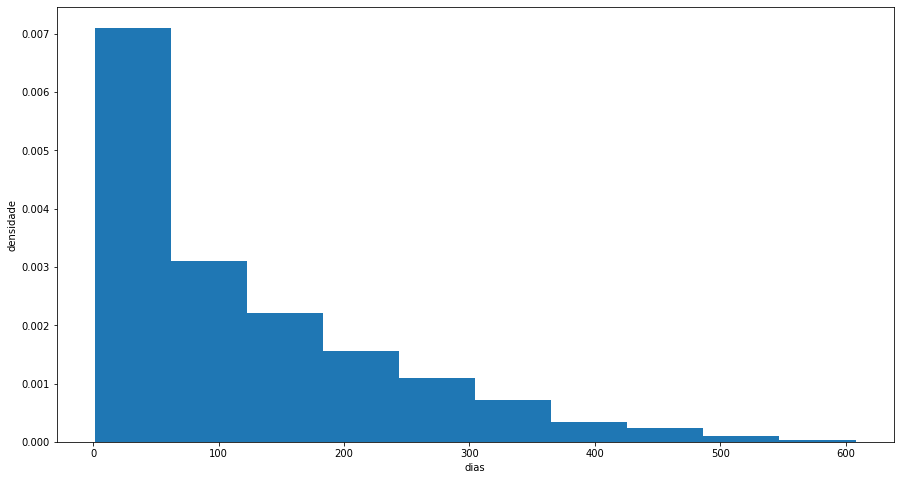

In [ ]:
#distribuição da recência máxima por clientes recorrentes
plt.figure(figsize=(15,8))
plt.hist(df_transactions_2.groupby('customer_unique_id').date_diff.max(),density = True)
plt.xlabel("dias")
plt.ylabel("densidade")
plt.show()

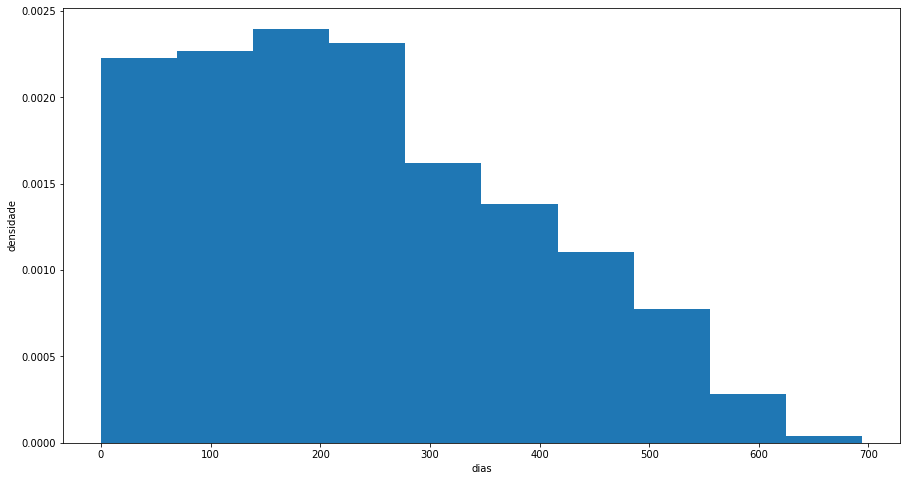

In [ ]:
#distribuição da recência histórica para base completa
plt.figure(figsize=(15,8))
plt.hist(df_rfm['rfm_recency'],density = True)
plt.xlabel("dias")
plt.ylabel("densidade")
plt.show()

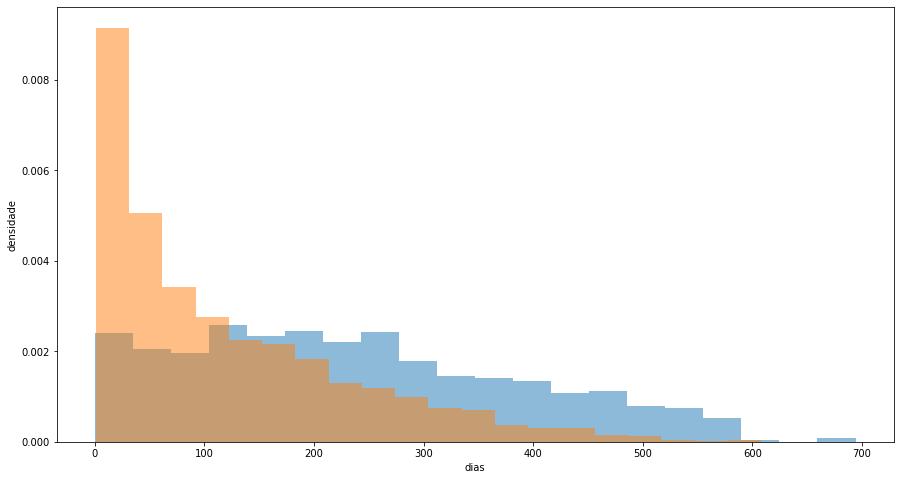

In [ ]:
plt.figure(figsize=(15,8))
plt.hist(df_rfm['rfm_recency'],density = True,alpha = 0.5, bins = 20)
plt.hist(df_transactions_2.groupby('customer_unique_id').date_diff.max(), density = True,alpha=0.5, bins = 20)
plt.xlabel("dias")
plt.ylabel("densidade")
plt.show()

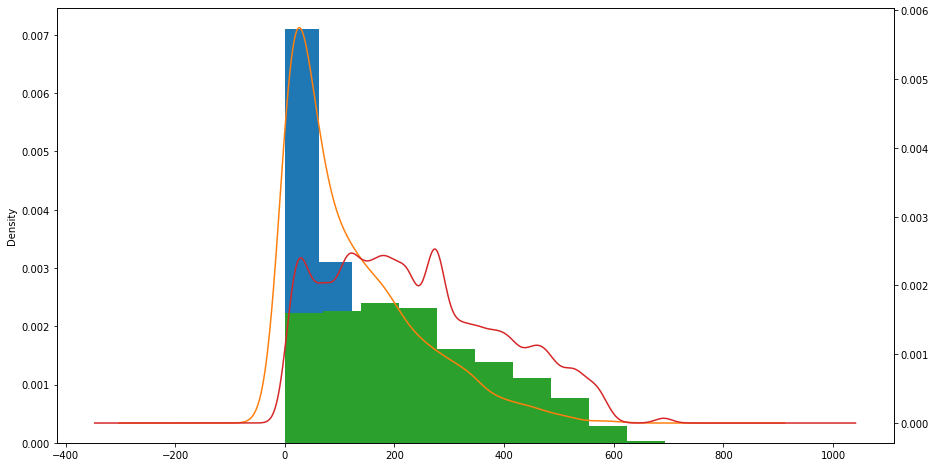

In [ ]:
#plot com hist e kde date_diff
plt.figure(figsize=(15,8))
zeta = df_transactions_2.groupby('customer_unique_id').date_diff.max()
ax = zeta.plot(kind='hist', density = True)
zeta.plot(kind='kde', ax = ax, secondary_y = True)

#plot com hist e kde recencia global
az = df_rfm.rfm_recency.plot(kind='hist',density = True)
df_rfm.rfm_recency.plot(kind='kde', ax = az, secondary_y = True)

plt.show()

In [ ]:
#identificando a intersecção dos kde
var_tst1 = df_rfm['rfm_recency']
var_tst2 = df_transactions_2.groupby('customer_unique_id').date_diff.max()

density1 = stats.gaussian_kde(var_tst1)
density2 = stats.gaussian_kde(var_tst2)

data_space = np.linspace(var_tst1.min(), var_tst1.max(), num=2000)
data_space2 = np.linspace(var_tst1.min(), var_tst1.max(), num=2000)

evaluated = density1.evaluate(data_space)
evaluated2 = density2.evaluate(data_space2)

cruzamento = var_tst1.min()

for i,x in enumerate(zip(evaluated,evaluated2)):
  if x[1] - x[0] <= 0:
    cruzamento = data_space[i]
    break

print(cruzamento)

139.2166083041521


Portanto, o **Churn** é determinado a partir de 139 dias sem transação


#### Churn entre transações

Uma vez definido o churn, é necessário identificar se os clientes com mais de uma transação atingiram esse valor que classifica a morte entre uma transação e outra, se sim, as transações realizadas após a morte do cliente são descartadas da base.

In [ ]:
df_all_recency = df_transactions.copy()
df_all_recency = df_all_recency[['customer_unique_id','order_id','order_purchase_timestamp']]
df_all_recency = df_all_recency.sort_values(['customer_unique_id','order_purchase_timestamp'])

df_all_recency = pd.merge(df_all_recency,df_rfm, on = 'customer_unique_id')

#coluna para próxima transação
df_all_recency['prev_order'] = df_all_recency.groupby('customer_unique_id')['order_purchase_timestamp'].shift(1)

#diferença entre as transações
df_all_recency['date_diff'] = (df_all_recency['order_purchase_timestamp'] - df_all_recency['prev_order']).dt.days

#df_all_recency['date_diff'] = df_all_recency['date_diff'].fillna(df_all_recency['rfm_recency'])

df_all_recency.drop(['rfm_monetary'], axis = 1, inplace = True)
df_all_recency

,customer_unique_id,order_id,order_purchase_timestamp,rfm_recency,rfm_frequency,prev_order,date_diff
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,111,1,NaT,NaN
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,114,1,NaT,NaN
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,536,1,NaT,NaN
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,320,1,NaT,NaN
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,287,1,NaT,NaN
...,...,...,...,...,...,...,...
96472,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08 21:00:36,446,1,NaT,NaN
96473,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,261,1,NaT,NaN
96474,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07 15:49:16,567,1,NaT,NaN
96475,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02 15:17:41,118,1,NaT,NaN


In [ ]:
#recência entre transações
df_should_be_dead = df_all_recency.copy()
df_should_be_dead = df_should_be_dead.sort_values(['customer_unique_id','order_purchase_timestamp'])
df_should_be_dead['drop_order'] = np.where(df_should_be_dead['date_diff'] >= 139, 1, 0)
df_should_be_dead['drop_order'] = np.where((df_should_be_dead['date_diff'] >= 139) | (df_should_be_dead.groupby('customer_unique_id')['drop_order'].shift() == 1) , 1, 0)
df_should_be_dead

,customer_unique_id,order_id,order_purchase_timestamp,rfm_recency,rfm_frequency,prev_order,date_diff,drop_order
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,111,1,NaT,NaN,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,114,1,NaT,NaN,0
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,536,1,NaT,NaN,0
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,320,1,NaT,NaN,0
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,287,1,NaT,NaN,0
...,...,...,...,...,...,...,...,...
96472,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08 21:00:36,446,1,NaT,NaN,0
96473,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,261,1,NaT,NaN,0
96474,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07 15:49:16,567,1,NaT,NaN,0
96475,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02 15:17:41,118,1,NaT,NaN,0


In [ ]:
#quantidade de transações "mortas"
df_should_be_dead.drop_order.sum()

739

In [ ]:
#identificando transações "mortas"
order_dead = df_should_be_dead.query('drop_order == 1')
order_dead.sort_values(['customer_unique_id','order_purchase_timestamp'])

,customer_unique_id,order_id,order_purchase_timestamp,rfm_recency,rfm_frequency,prev_order,date_diff,drop_order
105,004288347e5e88a27ded2bb23747066c,08204559bebd39e09ee52dcb56d8faa2,2018-01-14 07:36:54,227,2,2017-07-27 14:13:03,170.0,1
424,011b4adcd54683b480c4d841250a987f,93b35affb86435b71ca01a6dd1eab2b1,2018-02-15 11:40:57,195,2,2017-08-22 12:51:29,176.0,1
434,012452d40dafae4df401bced74cdb490,e49d0607832db7c3b1343764225d8df6,2018-05-14 12:12:45,107,2,2017-06-18 22:46:42,329.0,1
556,0178b244a5c281fb2ade54038dd4b161,94ca38619d7e64f94facac403a99682d,2018-07-28 13:13:00,32,2,2017-05-10 20:04:09,443.0,1
681,01c289bb06354cdc7e6549570f20ada4,6e7e9fd0c7c9256e1119cbb95fd12bce,2017-12-26 21:14:43,245,2,2017-06-03 19:11:14,206.0,1
...,...,...,...,...,...,...,...,...
95286,fcd0ab79592faab19e2bf386cf69fbcd,57db3577cc4d6b5ab2b9849d29c3fc61,2018-04-07 21:18:46,143,2,2017-02-10 23:23:35,420.0,1
95813,fe3e52de024b82706717c38c8e183084,54ba74414bed49a8b13864b3e8666f57,2018-07-31 08:30:27,29,2,2017-09-12 09:21:38,321.0,1
96303,ff8892f7c26aa0446da53d01b18df463,1c308eca3f339414a92e518e2a2e5ee9,2017-11-26 23:25:43,275,2,2017-05-24 16:09:14,186.0,1
96322,ff922bdd6bafcdf99cb90d7f39cea5b3,5f79e2da24a52e76bc22897df03a7901,2017-08-23 13:15:29,349,3,2017-02-22 12:26:42,182.0,1


In [ ]:
order_dead.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739 entries, 105 to 96323
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        739 non-null    object        
 1   order_id                  739 non-null    object        
 2   order_purchase_timestamp  739 non-null    datetime64[ns]
 3   rfm_recency               739 non-null    int64         
 4   rfm_frequency             739 non-null    int64         
 5   prev_order                739 non-null    datetime64[ns]
 6   date_diff                 739 non-null    float64       
 7   drop_order                739 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 52.0+ KB


In [ ]:
#id das transações a serem descartadas
order_dead = order_dead[['order_id']]
order_dead

,order_id
105,08204559bebd39e09ee52dcb56d8faa2
424,93b35affb86435b71ca01a6dd1eab2b1
434,e49d0607832db7c3b1343764225d8df6
556,94ca38619d7e64f94facac403a99682d
681,6e7e9fd0c7c9256e1119cbb95fd12bce
...,...
95286,57db3577cc4d6b5ab2b9849d29c3fc61
95813,54ba74414bed49a8b13864b3e8666f57
96303,1c308eca3f339414a92e518e2a2e5ee9
96322,5f79e2da24a52e76bc22897df03a7901


In [ ]:
#df transações com as transações mortas excluidas
dead_order_mask = df_transactions['order_id'].isin(order_dead['order_id'])
df_transactions = df_transactions.loc[~dead_order_mask]
df_transactions

,order_id,order_status,order_purchase_timestamp,customer_unique_id,qtd_produto,tipo_produto,payment_value,freight_value,receita_liquida
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,1,utilidades_domesticas,38.71,8.72,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,1,perfumaria,141.46,22.76,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,1,automotivo,179.12,19.22,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,1,pet_shop,72.20,27.20,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,1,papelaria,28.62,8.72,19.90
...,...,...,...,...,...,...,...,...,...
96472,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,1,beleza_saude,85.08,13.08,72.00
96473,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,1,bebes,195.00,20.10,174.90
96474,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,1,eletrodomesticos_2,271.01,65.02,205.99
96475,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,2,informatica_acessorios,441.16,81.18,359.98


**Calcular RFM histórico novamente**


In [ ]:
#recência
global_recency = pd.DataFrame(df_transactions.groupby('customer_unique_id').order_purchase_timestamp.max())
global_recency.columns = ['ultima_compra']
global_recency['recencia'] = global_recency['ultima_compra'].max() - global_recency['ultima_compra']
global_recency['recencia']= global_recency['recencia'].dt.days

#frequência
global_frequency=pd.DataFrame(df_transactions.groupby('customer_unique_id')['order_id'].count())
global_frequency.columns = ['qtd_transacoes']

#valor monetário
global_monetary=pd.DataFrame(df_transactions[['customer_unique_id','receita_liquida']].groupby('customer_unique_id')['receita_liquida'].sum())
global_monetary

#tabela rfm
df_rfm=pd.merge(global_recency,global_frequency,on='customer_unique_id')
df_rfm=pd.merge(df_rfm,global_monetary,on='customer_unique_id')
df_rfm.drop(['ultima_compra'],axis=1,inplace=True)
df_rfm.columns=['rfm_recency','rfm_frequency','rfm_monetary']
df_rfm.reset_index()

,customer_unique_id,rfm_recency,rfm_frequency,rfm_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,536,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00
...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,446,1,1570.00
93353,fffea47cd6d3cc0a88bd621562a9d061,261,1,64.89
93354,ffff371b4d645b6ecea244b27531430a,567,1,89.90
93355,ffff5962728ec6157033ef9805bacc48,118,1,115.00


**Atualizar tabela dos clientes**

In [ ]:
#df clientes unicos
df_client = df_customers.drop('customer_id', axis=1)
df_client = df_client.drop_duplicates(subset = ['customer_unique_id'], keep = 'first')

#selecionando clientes das transações finalizadas
clientes_final = df_transactions['customer_unique_id'].drop_duplicates()
mask_cliente = df_client['customer_unique_id'].isin(clientes_final)
df_client = df_client.loc[mask_cliente]

#primeira compra por cliente
primeira_compra = df_transactions.groupby("customer_unique_id").order_purchase_timestamp.min().reset_index()
primeira_compra.columns = ['customer_unique_id','primeira_compra']

#ultima compra por cliente
ultima_compra = df_transactions.groupby("customer_unique_id").order_purchase_timestamp.max().reset_index()
ultima_compra.columns = ['customer_unique_id','ultima_compra']

#new customer dataset
df_client = pd.merge(df_client, primeira_compra, on = "customer_unique_id")
df_client = pd.merge(df_client,ultima_compra, on = "customer_unique_id")

# + RFM table
df_client = pd.merge(df_client,df_rfm, on = 'customer_unique_id')

#ticket médio por cliente
df_client['ticket_medio'] = df_client['rfm_monetary'] / df_client['rfm_frequency']

#tempo de vida dos clientes
df_client['retencao'] = (df_client['ultima_compra'] - df_client['primeira_compra']).dt.days

#### Identificando clientes vivos e mortos

A classificação do churn por cliente é dada pela recência rfm, onde se houver mais de 139 desde sua ultima transação, ele é classificado como morto


*   churn = 1 (morto)
*   churn = 0 (vivo)



In [ ]:
#criterio do churn (if recency > 139)
df_client['Churn'] = np.where(df_client['rfm_recency'] >= 139, 1, 0)
df_client

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,primeira_compra,ultima_compra,rfm_recency,rfm_frequency,rfm_monetary,ticket_medio,retencao,Churn
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,2017-05-16 15:05:35,2017-05-16 15:05:35,469,1,124.99,124.99,0,1
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,2018-01-12 20:48:24,2018-01-12 20:48:24,228,1,289.00,289.00,0,1
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,2018-05-19 16:07:45,2018-05-19 16:07:45,101,1,139.94,139.94,0,0
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,2018-03-13 16:06:38,2018-03-13 16:06:38,168,1,149.94,149.94,0,1
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,2018-07-29 09:51:30,2018-07-29 09:51:30,31,1,230.00,230.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
93352,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,2018-04-07 15:48:17,2018-04-07 15:48:17,143,1,74.90,74.90,0,1
93353,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,2018-04-04 08:20:22,2018-04-04 08:20:22,147,1,114.90,114.90,0,1
93354,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,2018-04-08 20:11:50,2018-04-08 20:11:50,142,1,37.00,37.00,0,1
93355,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,2017-11-03 21:08:33,2017-11-03 21:08:33,298,1,689.00,689.00,0,1


In [ ]:
#total de clientes mortos e vivos
df_client.groupby('Churn')['customer_unique_id'].nunique().sort_values(ascending=False).reset_index()

,Churn,customer_unique_id
0,1,64604
1,0,28753
